In [1]:
from IPython.core.display import display, HTML
import warnings
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.simplefilter("ignore")

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd
import logging

import sys

sys.path.append("third_party/mlos/source/Mlos.Python")
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Spaces import SimpleHypergrid, ContinuousDimension
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Spaces import Point
from mlos.Logger import create_logger
sys.path.remove('third_party/mlos/source/Mlos.Python')

%matplotlib notebook

np.random.seed(47)

# Lab 1
This is the notebook file for Lab 1. Go through the cells one-by-one and fill any parts of code or answer any questions when specified. Your notebook is complete once you have filled these parts, successfully executed them, plotted the results (when applicable) and answered questions. Once complete, you will upload the notebook via Canvas.

Good luck!

- - - 
- - -

# Bayesian Optimization
In this notebook we will get to know the basics behind a black-box optimization method called [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization).

Almost all algorithms and solutions to Computer Science problems are characterized by hyperparameters. The behaviour of the algorithm and subsequently, how well it performs in that problem depends on tuning these hyperparameters correctly. For instance, machine learning problems are significantly affected by learning rate, or key-value databases by the number of shards. To make matters worse, the problem circumstance (workload distribution, batch size, ...) affect how well the hyperparameters will work and a universally tuned set does not exist.

We can formulate an optimization problem to tune these hyperparameters. We have an end-goal objective $f(X)$ (training loss, fetch latency, QoE metrics) affected by several hyperparameters, denoted as a vector $X$. The function does not have to be differentiable (directly or indirectly) w.r.t the hyperparameters and it does not have be convex either. With these limitations, we can turn to black-box optimization methods, which take a function and input space and report the set of parameters that minimize (or maximize) it. Bayesian optimization (BO) is a type of black-box optimization method. Quite simply, bayesian optimization fits a 'prior' to the samples it has seen so far and constructs a 'belief' about the objective function. This belief allows it both predict the objective function for some point and report the uncertainty of that prediction. Using this belief, BO can decide what sample can make its end-result more accurate. We will soon see in more detail how all of this is done.

To introduce Bayesian Optimization, we will start with a simple example. Here we have a synthetic objective function that we intend to minimize.

In [2]:
# Our objective function. 
def objective(x, theta=0.02):
    x = np.array(x)
    return (1.2*np.sin(x-0.7)*np.exp(-(x-0.5)**2/0.2)-0.5*np.cos(6*(x-3.9))*np.exp(-(x-3)**2/0.7)) + np.random.normal(0, theta, size=x.shape)

Run the cell below to plot the objective function over the input space. Note that while you can see the function in this example (blue line), in a real problem you can only sample the function in the real-world. That means you can only see the orange markers.

Note that many times, the objective function might be an expectation over a distribution and thus it's sample can be noisy. This is why we also add a small noise to the objective to mimic this behaviour. This will affect our approach to the optimization problem too.

<IPython.core.display.Javascript object>


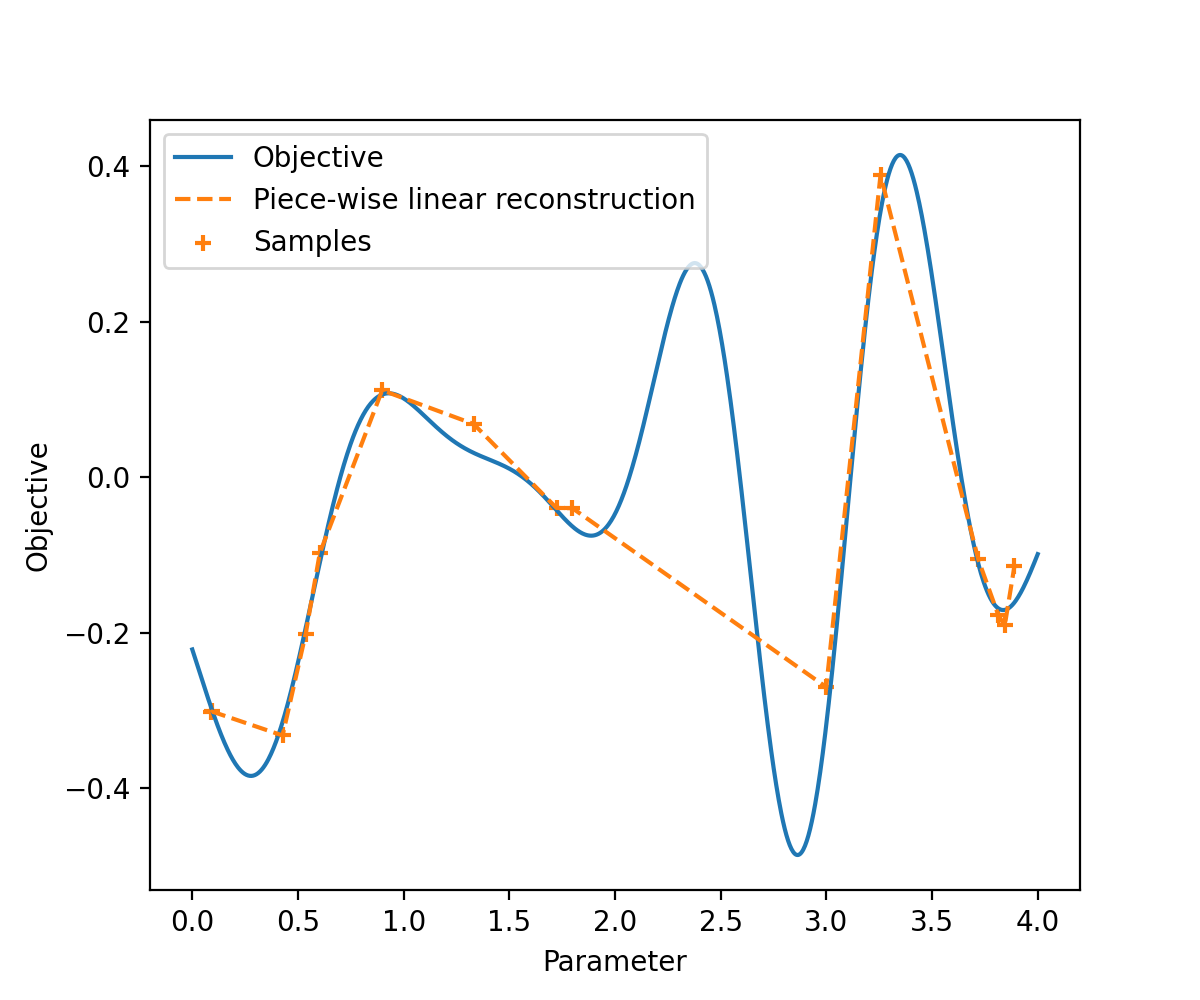

In [3]:
# The 1-dim input space.
X_all = np.linspace(0, 4, 1000)
X_all = np.expand_dims(X_all, -1)
# The expectation of the objective function (or in other words, the objective function with no noise)
Y_all = objective(X_all, 0)

plt.figure(figsize=(6, 5))
plt.plot(X_all, Y_all, label='Objective')
plt.xlabel('Parameter')
plt.ylabel('Objective')

# A set of random samples in the input space
X_s = np.random.random(size=(15, 1))*4
Y_s = objective(X_s)

plt.scatter(X_s, Y_s, color='C1', marker='+', label='Samples')
plt.plot(np.sort(X_s.squeeze()), Y_s[np.argsort(X_s.squeeze())], color='C1', linestyle='--', label='Piece-wise linear reconstruction')

plt.legend()

# Assigment 1
What is the simplest optimization strategy here?
Randomly sample the input space and report the minimum sample. As easy as this sounds, it is a brute force optimization method and hungry for samples. Sampling is costly and this method is not tractable. Also, the objective function input space is 1-dimensional here, but if it was multi-dimensional, the sample complexity of this approach would skyrocket.

Nevertheless, we need a starting point to compare with our BO approach. We first have to define a metric for comparison. Suppose the minimizing hyperparameter value, i.e the output of the optimization scheme, is some $\hat{x}$ and the actual global minimum is $x^*$. Let the error be the absolute difference in the resulting objective values:
$$err = |f(\hat{x})-f(x^*)|$$

Plot the **expectation** of this error (y-axis) metric against the number of random samples (x-axis). Note that the error depends a lot on the random samples drawn and to have a reliable plot, you need to repeat each experiment a number of times (10-1000 times). We have chosen the set of sample counts you will be tesing on for you.

In [ ]:
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
error_simple = np.empty_like(sample_space, dtype=float)

###### Assignment 1
# Compute the error of the explained approach.
###### 

plt.figure(figsize=(6, 5))
plt.plot(sample_space, error_simple, color='C0', label='Direct minimization')
plt.xlabel('Number of samples')
plt.ylabel('Absolute error')
plt.show()

# Bayesian Optimization and Gaussian Processes
A different route to minimzation would be to fit some function to the samples. We call this the surrogate model. We can use the surrogate to decide where the minimizing point is.
BO will fit the samples to a random process and form this surrogate. An example of a well-known random process is a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process). A gaussian process is a collection of random variables indexed by some parameter. The random variables are correlated w.r.t to their indices. For example, random variables that have a small distance in their index (parameter value) are very correlated (and hence the function is smooth).

We will use the [SciKit-Learn](https://scikit-learn.org/stable/index.html) implementation of the Gaussian process and regressor to show you what this looks like. 

In [4]:
# You can create a model like this
model = GaussianProcessRegressor()
# And fit it to the samples like this
model.fit(X_s, Y_s);

You can see an example of a Gaussian process fitted to the same samples you saw before. Notice how well the surrogate predicts where samples are abundant and where it fails when samples are sparse. You can try giving the model a different set/number of samples to see how it changes.

<IPython.core.display.Javascript object>


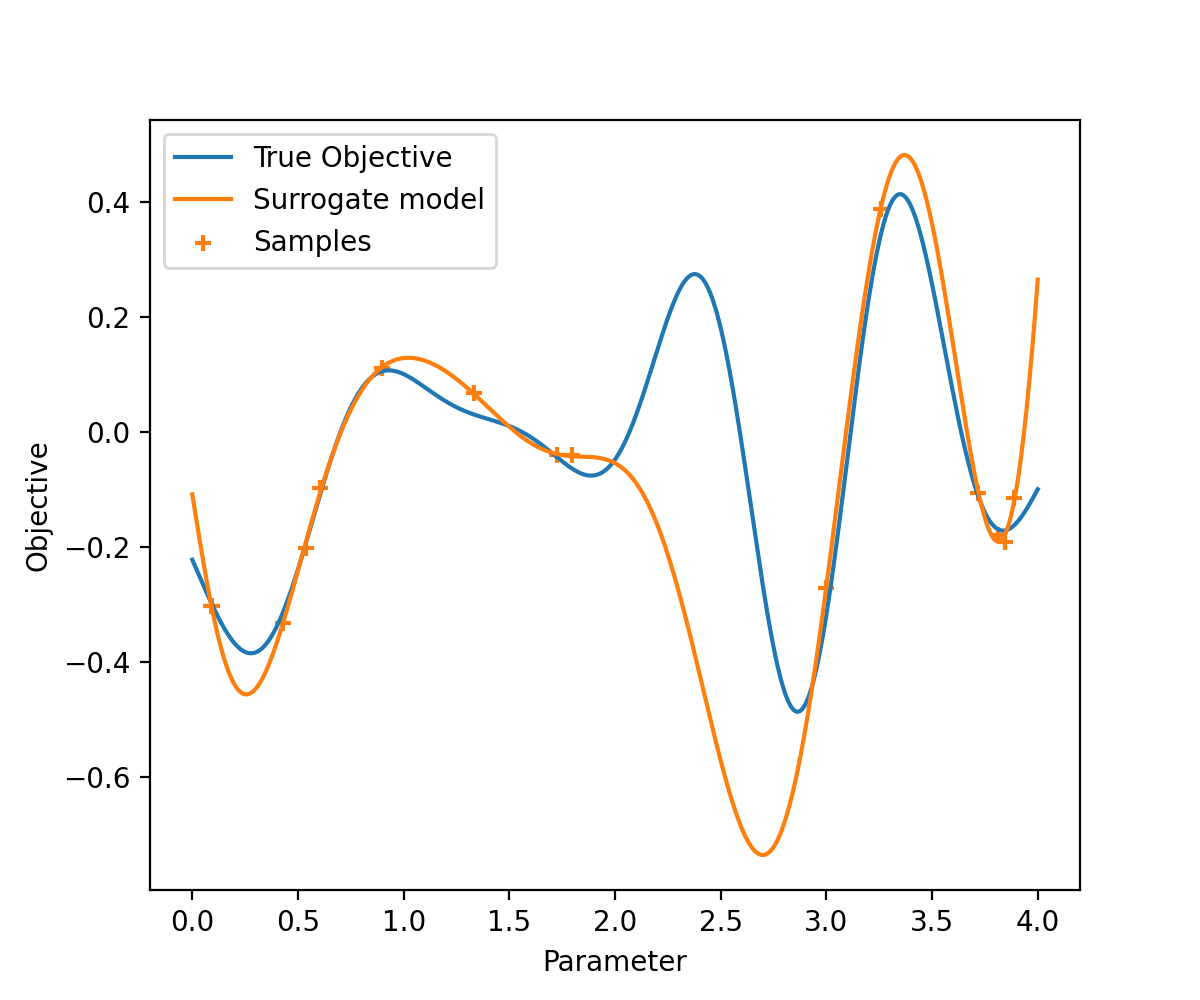

In [5]:
def plot_model(model, X_all, Y_all, X_s, Y_s, std=False):
    y_pred, sigma = model.predict(X_all, return_std=True)

    plt.figure(figsize=(6, 5))
    plt.plot(X_all, Y_all, label='True Objective')
    plt.plot(X_all, y_pred, label='Surrogate model')
    plt.scatter(X_s, Y_s, color='C1', marker='+', label='Samples')
    if std:
        plt.fill_between(X_all[:, 0], y_pred[:, 0]+sigma, y_pred[:, 0]-sigma, color='C2', alpha=0.3)

    plt.xlabel('Parameter')
    plt.ylabel('Objective')
    plt.legend()

plot_model(model, X_all, Y_all, X_s, Y_s)

As we explained, a gaussian process is defined by the correlation between the random variables indexed by the parameter. This correlation is governed by a kernel function and the fitting process finds the correct set of kernel parameters that minimize the prediction error w.r.t to the samples.

You can try other kernels and see how they repond to these samples:

<IPython.core.display.Javascript object>


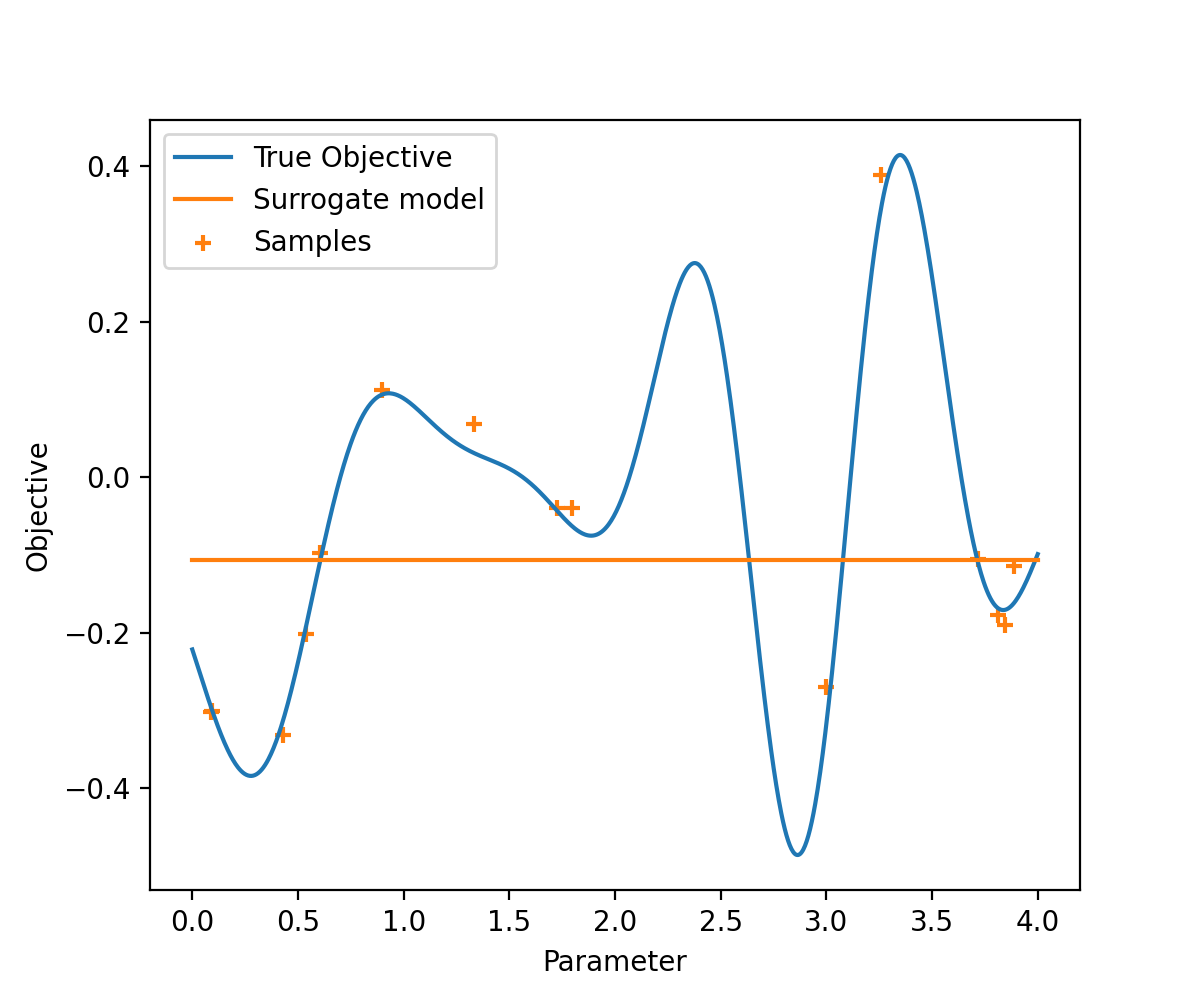

<IPython.core.display.Javascript object>


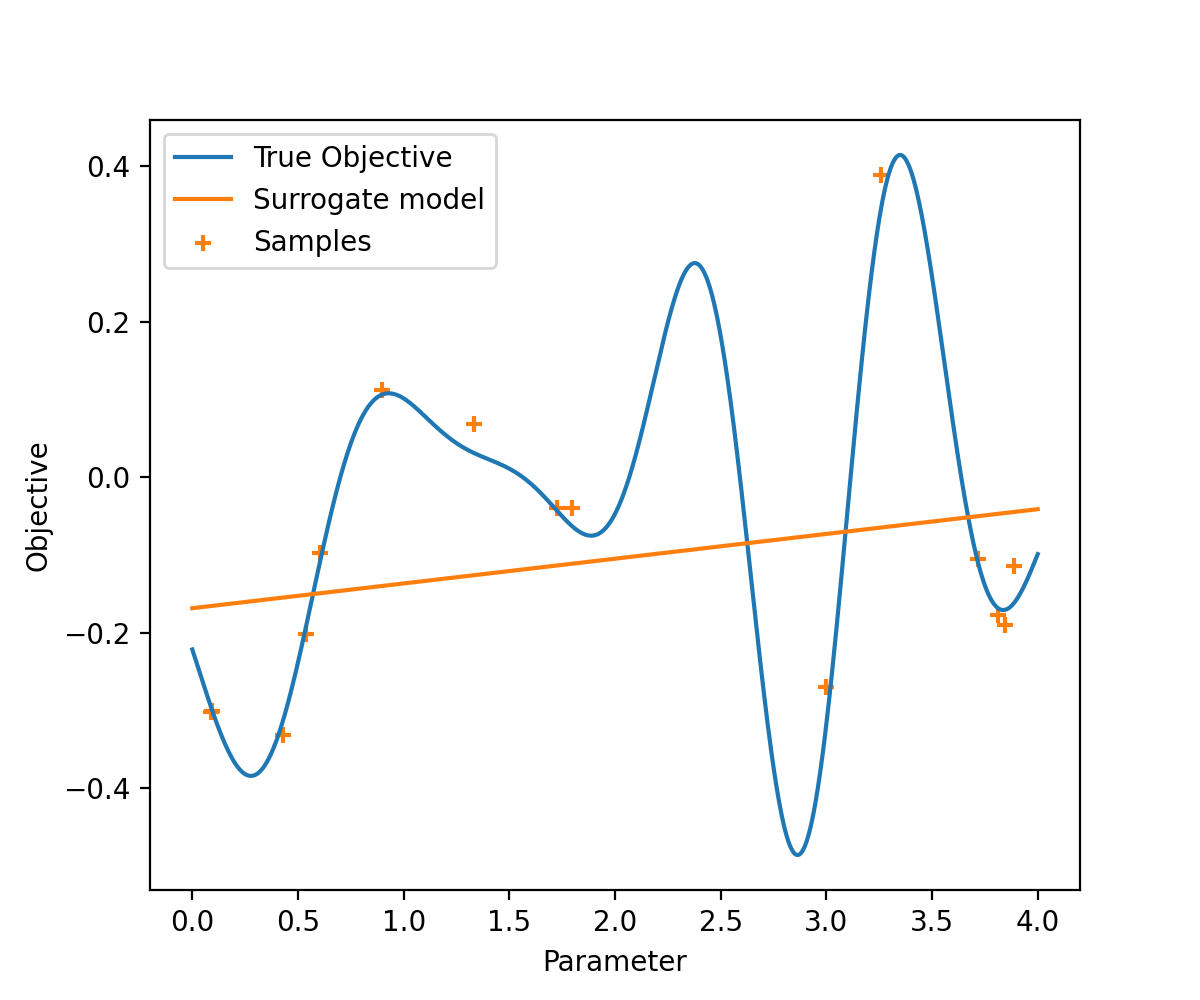

<IPython.core.display.Javascript object>


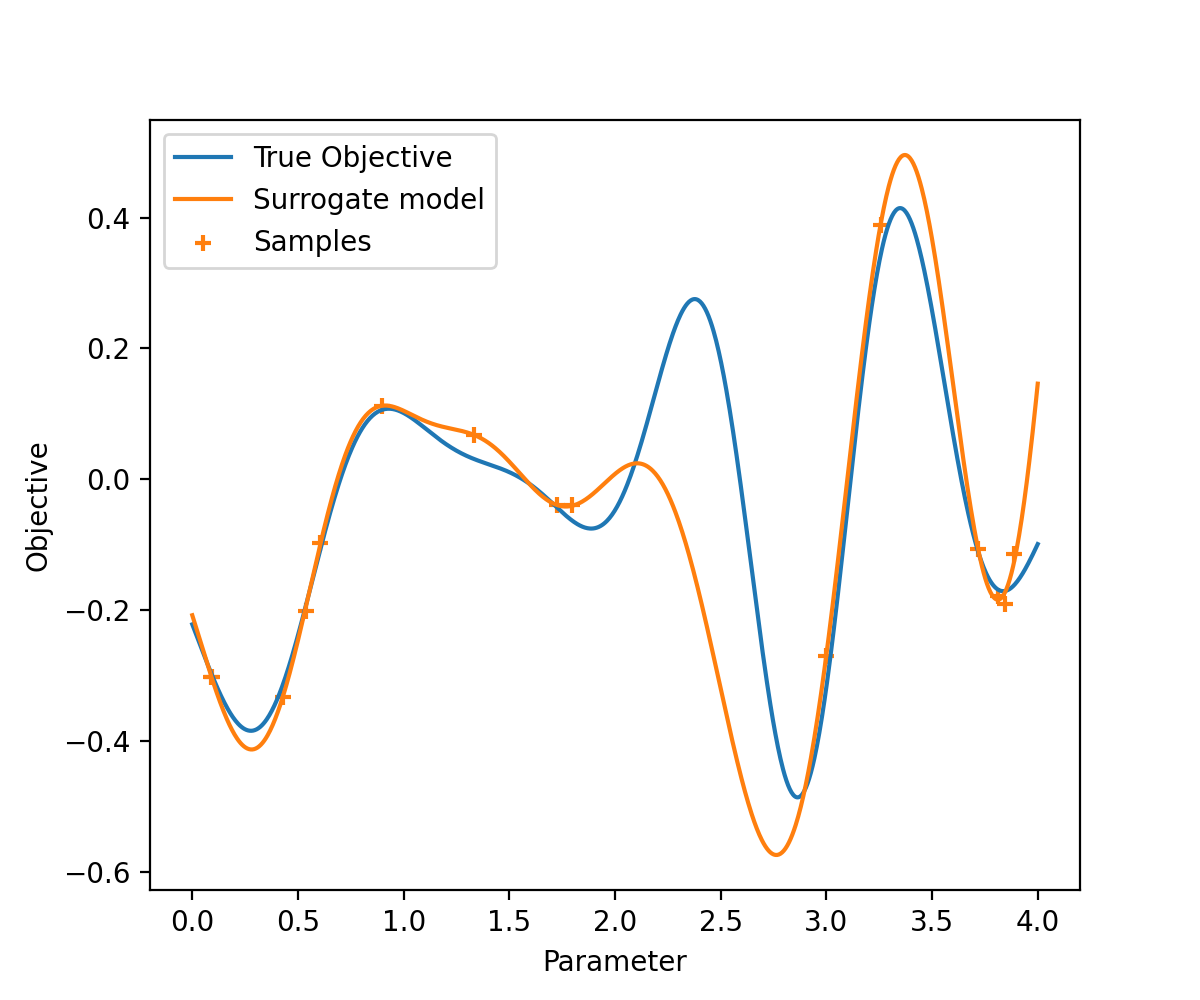

<IPython.core.display.Javascript object>


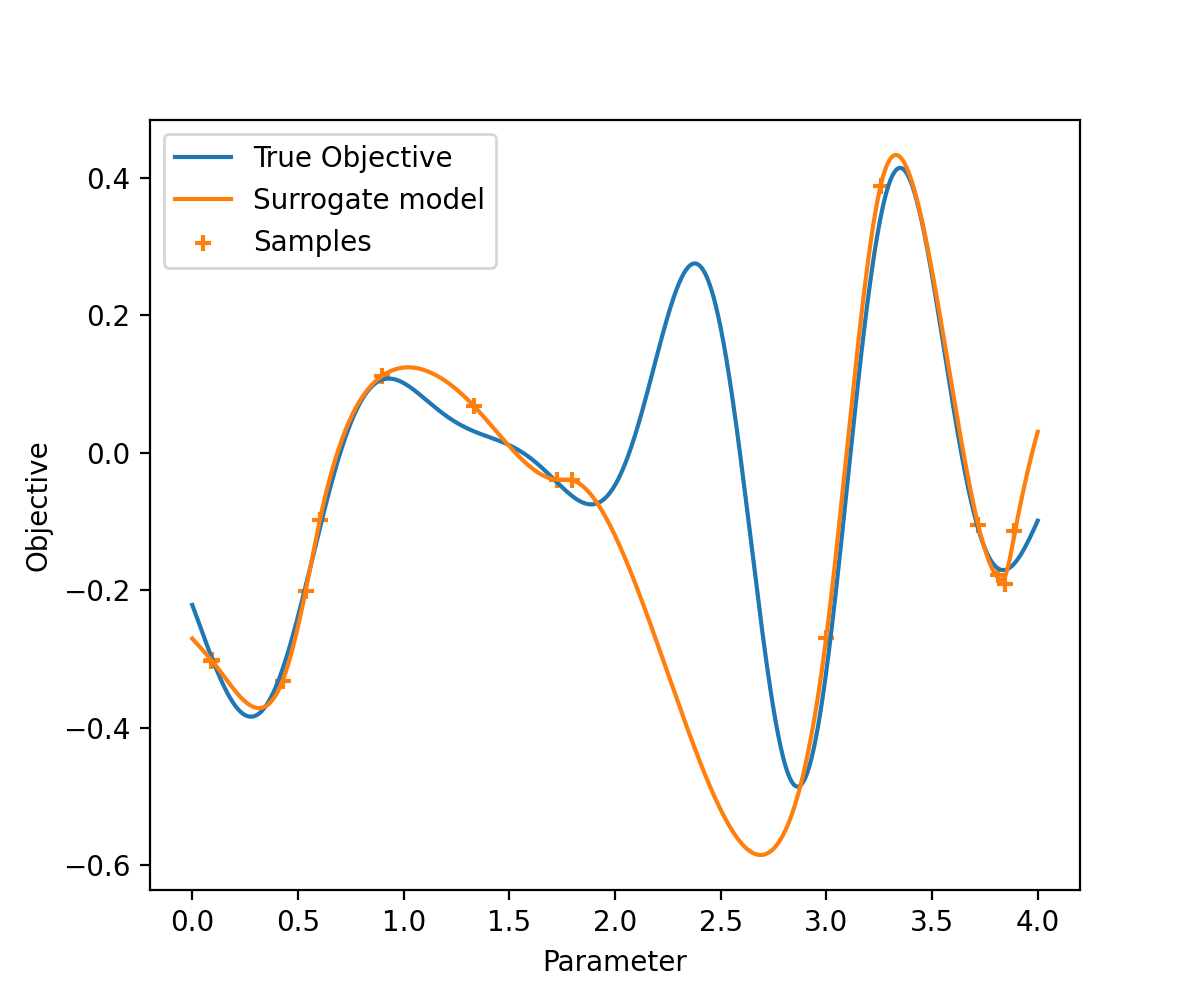

<IPython.core.display.Javascript object>


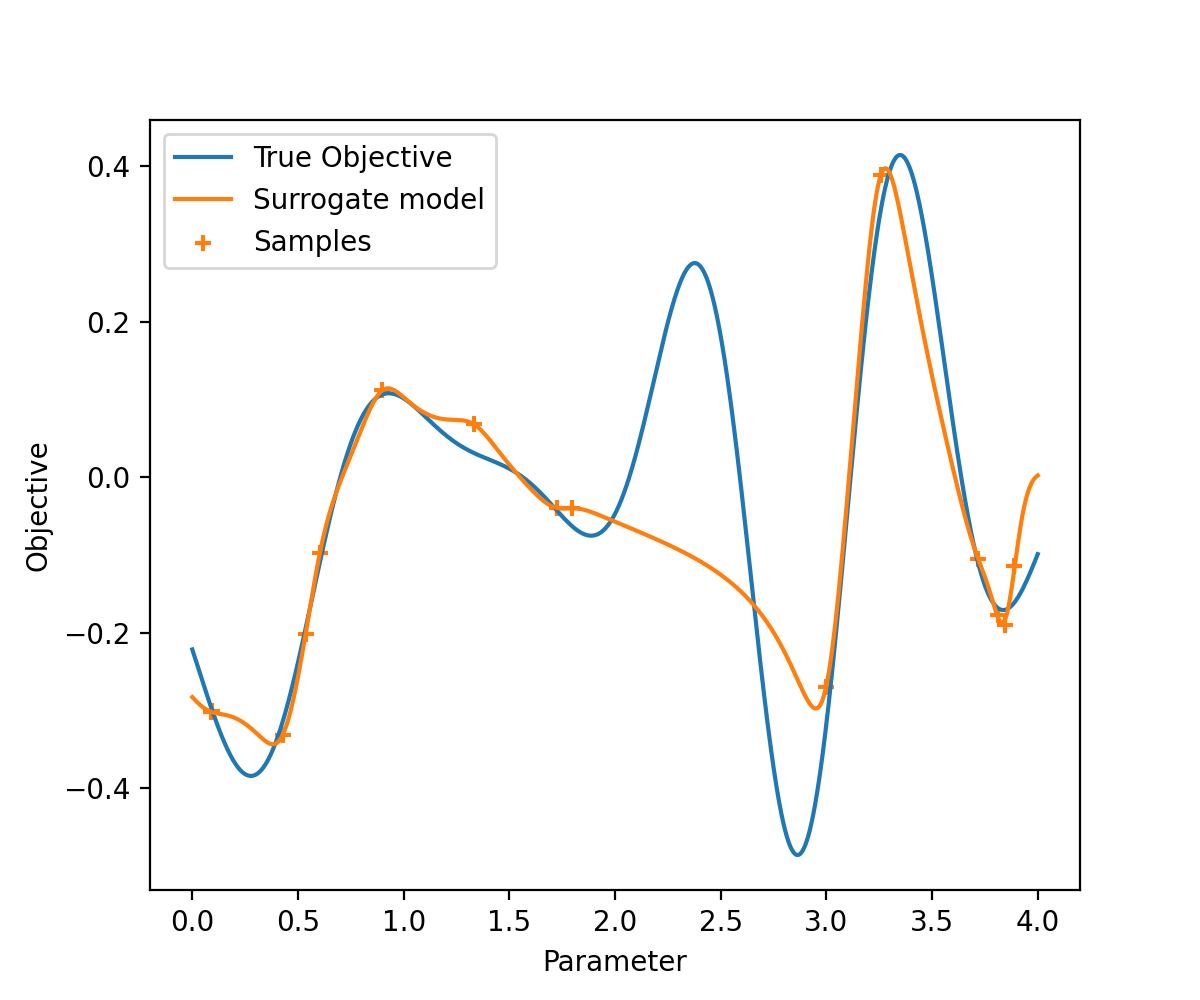

In [6]:
model = GaussianProcessRegressor(kernel=kernels.ConstantKernel(), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)

model = GaussianProcessRegressor(kernel=kernels.DotProduct(), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)

model = GaussianProcessRegressor(kernel=kernels.RBF(length_scale_bounds=(0, 10)), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)

model = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)

model = GaussianProcessRegressor(kernel=kernels.RationalQuadratic(), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)

You might have noticed an extra parameter (alpha) in our instantiation above. Remember how we said the objective function can be noisy? You can specify this in your gaussian process too. The effect is very noticable; The higher you set alpha, the more noisy the objective function is assumed to be, and errors are ignored in favor of a simpler kernel. If you set it too low, the regressor will aggresively try to fit the prior and not tolerate errors.

Try running the cell below to get a sense of its effect.

For the next set of experiments we recommend using the Matern kernel and setting alpha to 1e-4. You are free to experiment with other kernels and hyperparameters too, but choosing a wrong set of hyperparameters might affect the results.

<IPython.core.display.Javascript object>


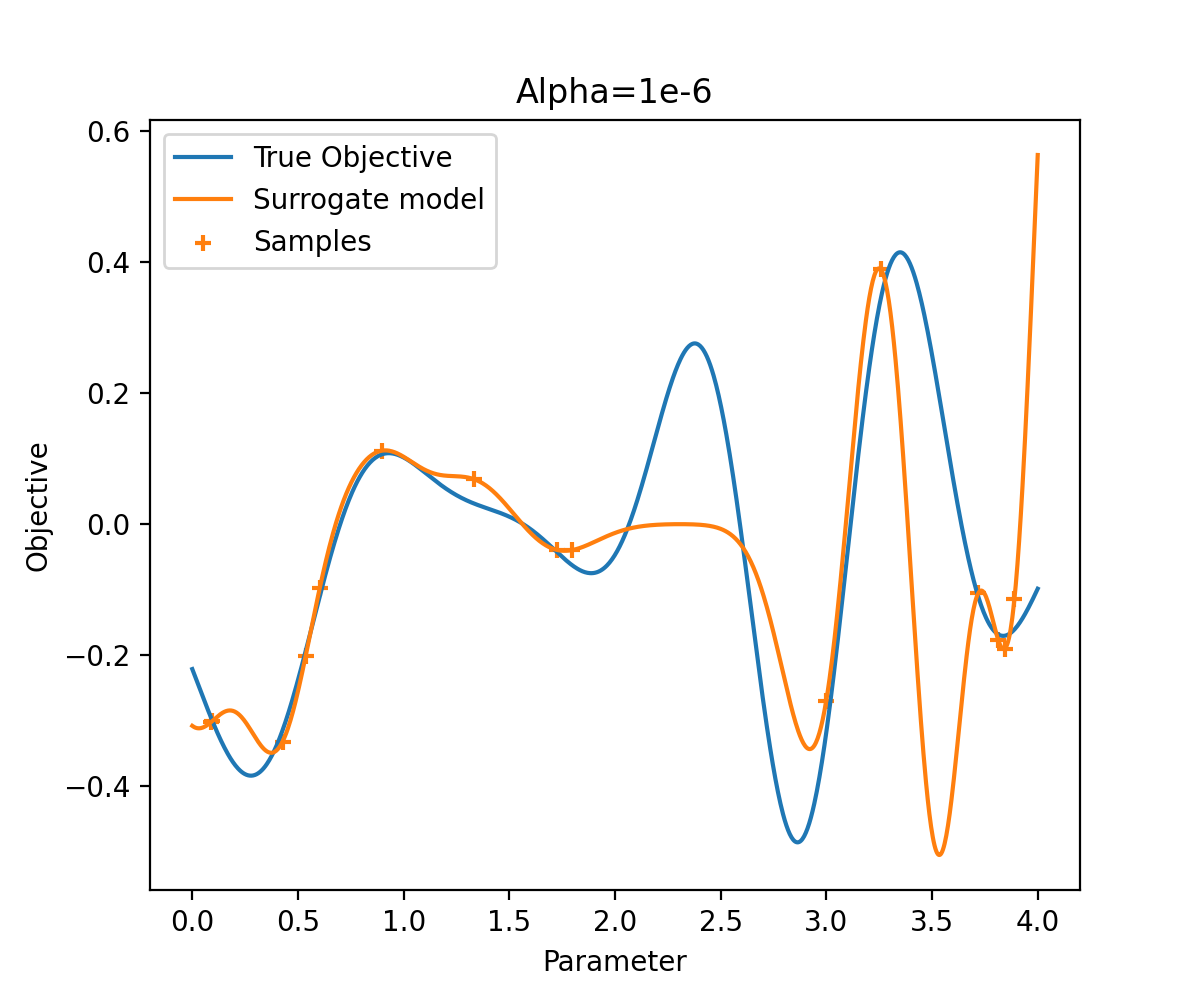

<IPython.core.display.Javascript object>


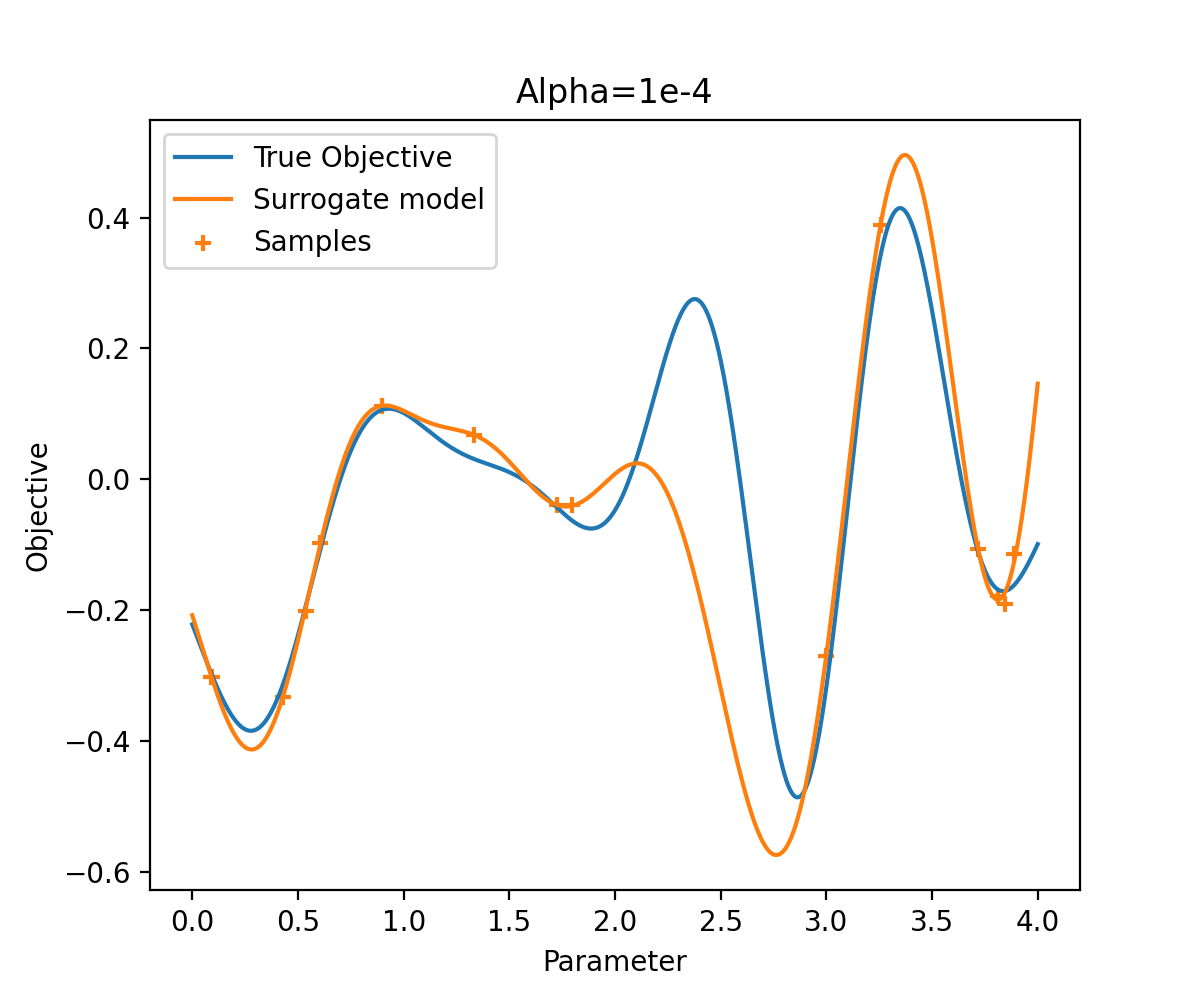

<IPython.core.display.Javascript object>


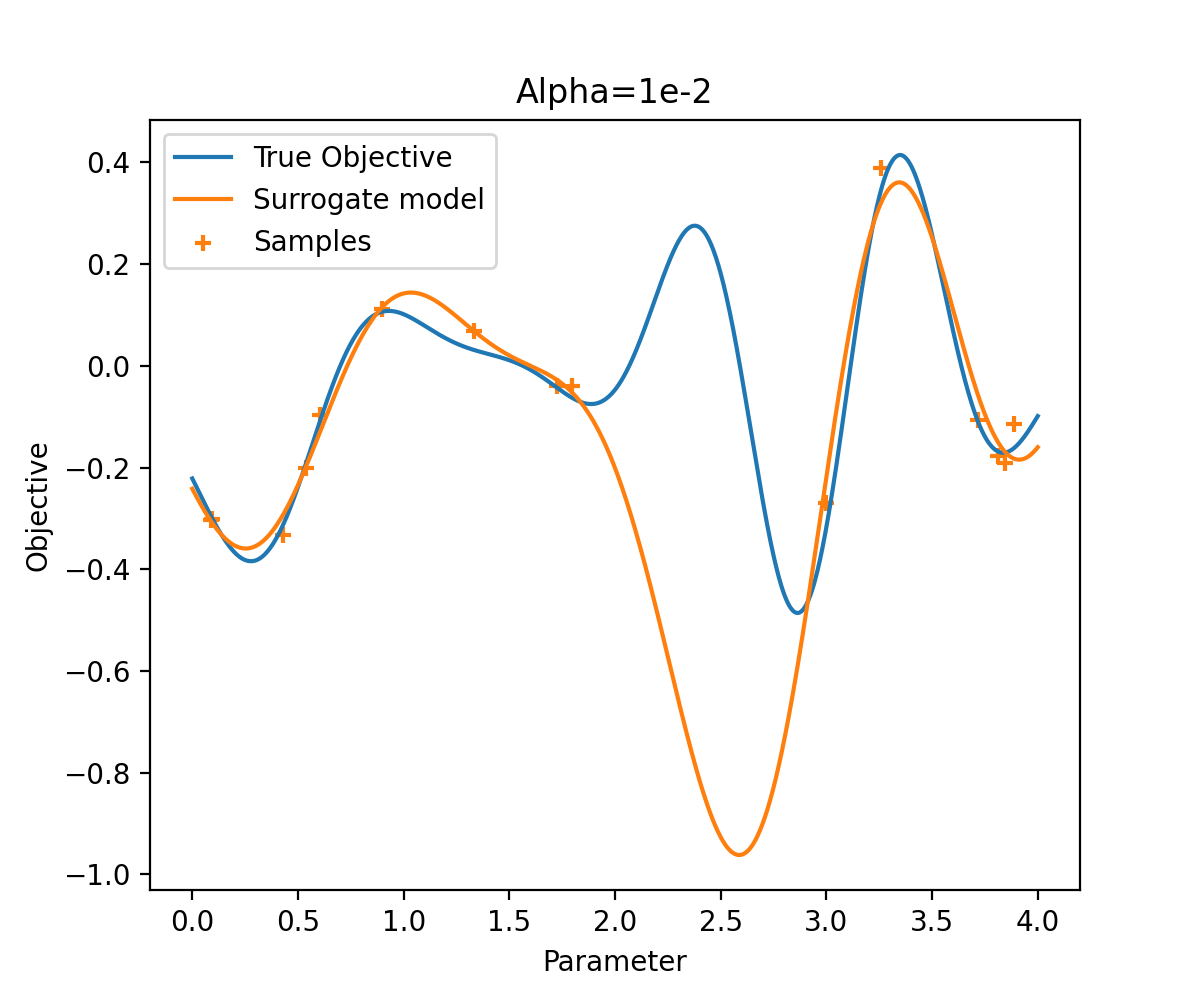

Text(0.5, 1.0, 'Alpha=1e-2')

In [7]:
model = GaussianProcessRegressor(kernel=kernels.RBF(length_scale_bounds=(0, 10)), alpha=1e-6).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)
plt.title('Alpha=1e-6')


model = GaussianProcessRegressor(kernel=kernels.RBF(length_scale_bounds=(0, 10)), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)
plt.title('Alpha=1e-4')


model = GaussianProcessRegressor(kernel=kernels.RBF(length_scale_bounds=(0, 10)), alpha=1e-2).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s)
plt.title('Alpha=1e-2')

Since each random variable indexed by the parameter is a gaussian random variable, there is an inherent uncertainty or variance in the model. This uncertainty describes how sure the model is of it's estimate at that point. We can visualize the uncertainty by coloring one standard deviation arrond the estimate.

<IPython.core.display.Javascript object>


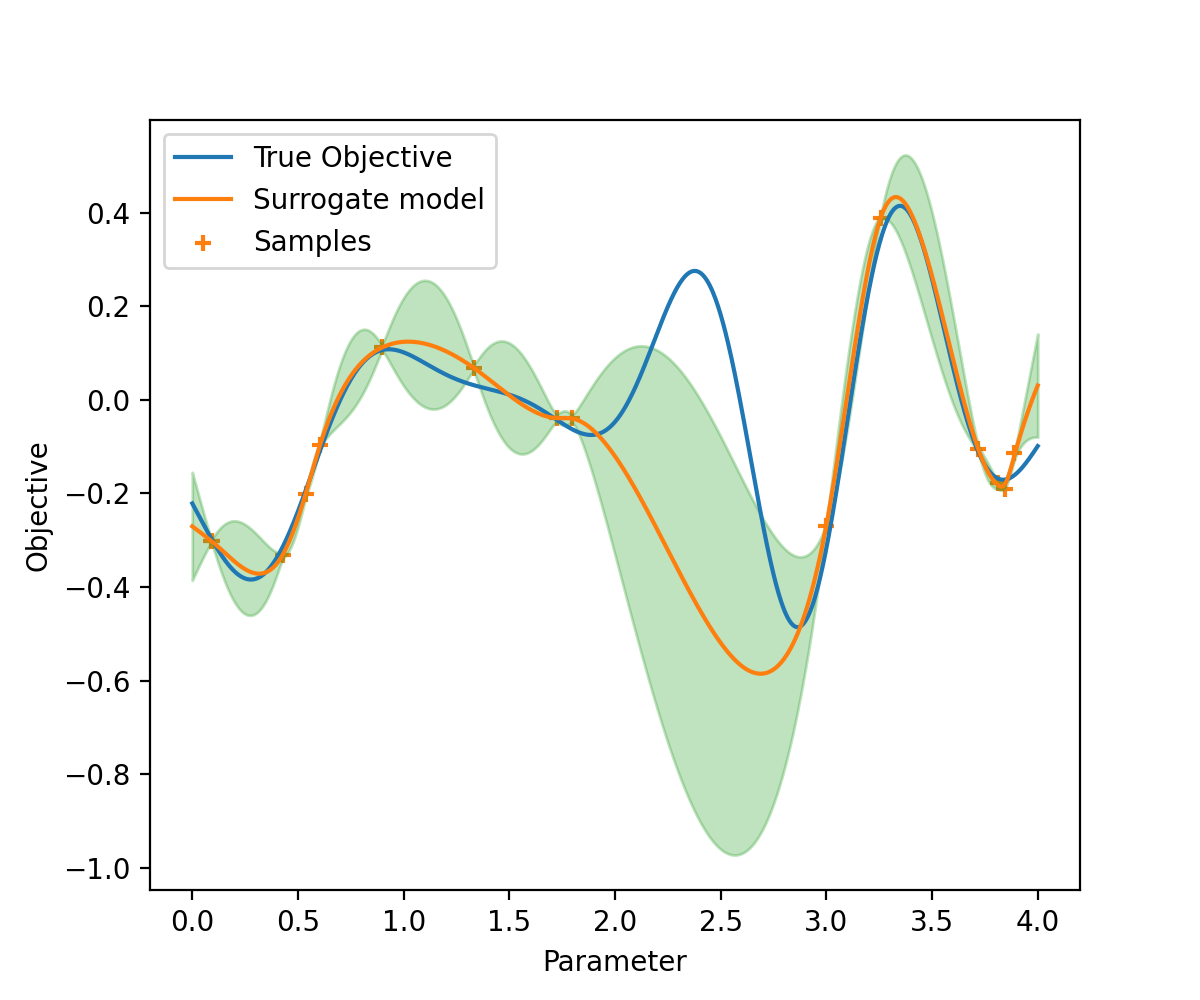

In [8]:
model = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e-4).fit(X_s, Y_s)
plot_model(model, X_all, Y_all, X_s, Y_s, std=True)

As more samples are added, the models estimates change. A region of the parameter space that was sparse in samples will have high uncertainty. Sampling that region and updating the model will improve the model prediction and decreases it's uncertainty. Note that the uncertainty takes 'alpha' into account; with a large alpha, the uncertainty will not reach zero with more samples.

<IPython.core.display.Javascript object>


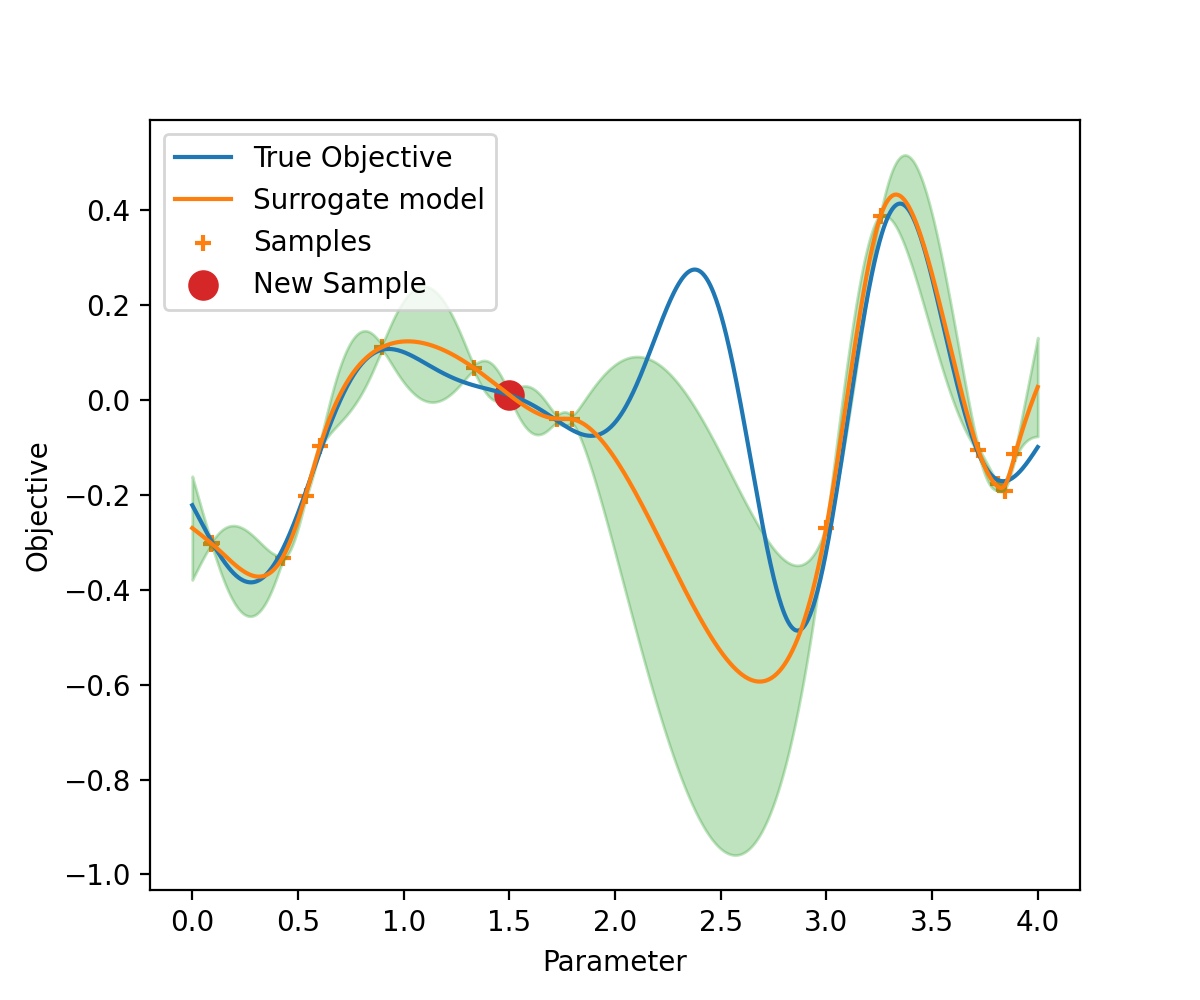

<IPython.core.display.Javascript object>


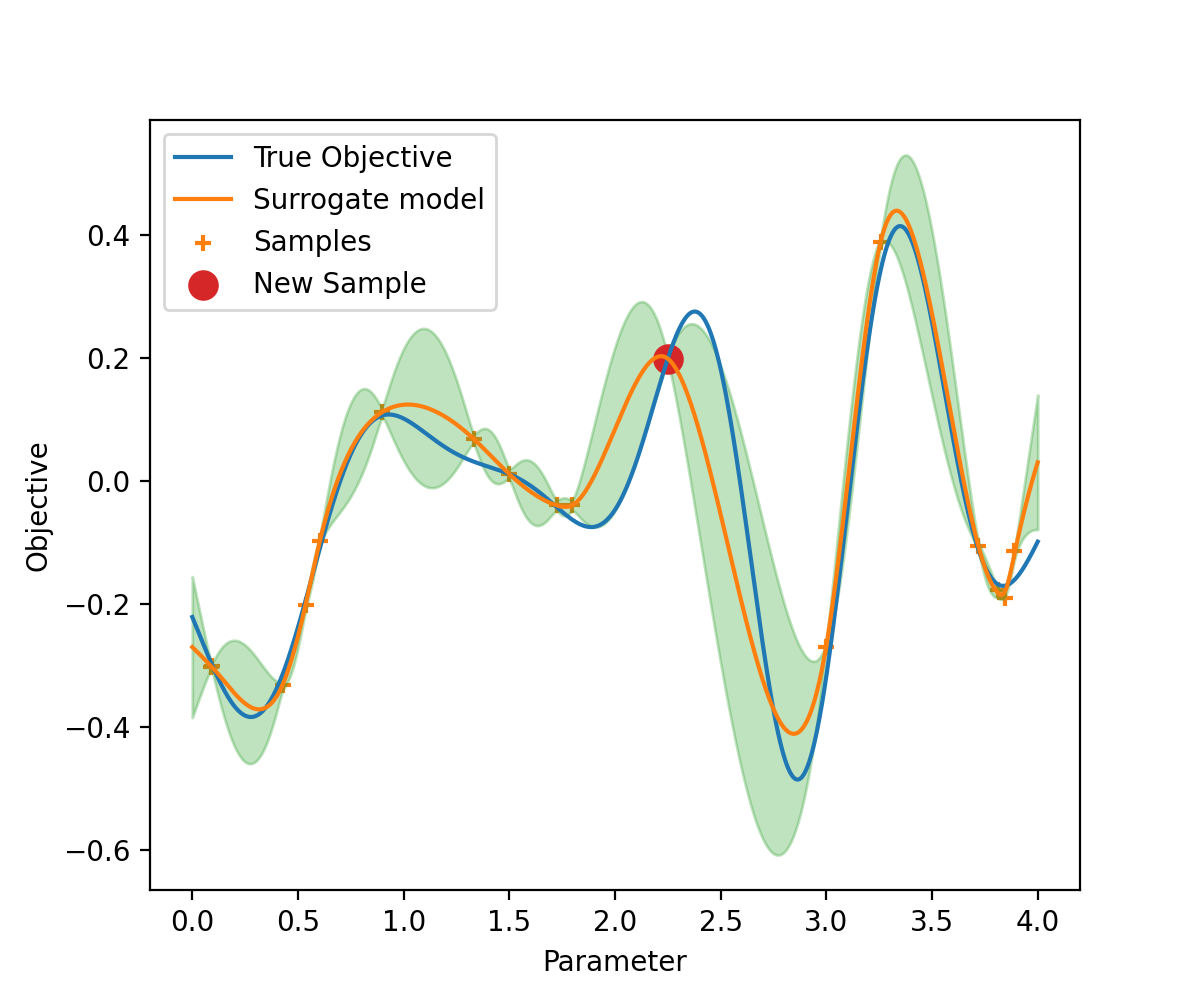

In [9]:
for x_new in [1.5, 2.25]:
    y_new = objective(x_new, 0)
    X_s = np.append(X_s, [[x_new]], axis=0)
    Y_s = np.append(Y_s, [[y_new]], axis=0)

    model.fit(X_s, Y_s)
    plot_model(model, X_all, Y_all, X_s[:-1], Y_s[:-1], std=True)
    plt.scatter(x_new, y_new, marker='o', s=100, color='C3', label='New Sample')
    plt.legend()

# Assigment 2
Now that we have got a sense of how the Gaussian process works, let's use it for optimization. What is the simplest optimization strategy, using the gaussian process?
Randomly sample the input space and fit a model $\mathcal{M}$ to the samples. Then report the minimizing sample $\hat{x}$ in the parameter space:
$$\hat{x} = \text{arg}\min_x{\mathcal{M}(x)}$$
Although it is very similar to our previous idea, we use a function to decide the minimizing parameter instead of the samples. So we expect more accuracy with the same number of samples, compared to our preivious approach.

Plot the **expectation** of this error (y-axis) metric against the number of random samples (x-axis). In practice, to find the minimum samples you could do something sophisticated like the [BFGS](https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm) numerical optimization method. Here, we recommend feeding a dense linear sampling of the input space (X_all):
```
X_all = np.linspace(0, 4, 1000)
X_all = np.expand_dims(X_all, -1)
y_pred = model.predict(X_all)
```

Question: How does the curve compare to our earlier approach? Can you explain why?

Your answer here:



In [ ]:
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
error_random = np.empty_like(sample_space, dtype=float)

###### Assignment 2
# Compute the error of the explained approach.
###### 

plt.figure(figsize=(6, 5))
plt.plot(sample_space, error_simple, color='C0', label='Direct minimization')
plt.plot(sample_space, error_random, color='C1', label='BO - Random sampling')
plt.xlabel('Number of samples')
plt.ylabel('Absolute error')
plt.legend()

# Assigment 3
Although using a Gaussian Process with our random samples gives us a slight improvement, it is still not enough. We have also neglected a new possibility that the GP brings up; Controlling the sampling. When our GP model fits a curve to our samples, it already gives us a clue about what samples would be closer to the minimizing point. By random sampling, we waste precious sampling choices on regions of the parameter space that are most likely not the minimizing point. Suppose samples are denoted by $x_i$, where $i$ is the iteration index. If the surrogate model with $i$ samples is $\mathcal{M}_i$, we have:
$$x_{i+1} = \text{arg}\min_x{\mathcal{M}_i(x)}$$

Plot the **expectation** of this error (y-axis) metric against the number of random samples (x-axis). It is best if you start with some number of random samples (5) and then iteratively add more with the strategy above. We recommend adding a small noise to the new sample at each iteration $x_{i+1}$ to avoid having two samples with the same parameter value.

Question: How does the curve look like? Why?

Hint: If the errors look bad, don't be alarmed.

Your answer here:

In [ ]:
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
error_greedy = np.empty_like(sample_space, dtype=float)

###### Assignment 3
# Compute the error of the explained approach.
###### 

plt.figure(figsize=(6, 5))
plt.plot(sample_space, error_simple, color='C0', label='Direct minimization')
plt.plot(sample_space, error_random, color='C1', label='BO - Random sampling')
plt.plot(sample_space, error_greedy, color='C2', label='BO - Greedy sampling')
plt.xlabel('Number of samples')
plt.ylabel('Absolute error')
plt.legend()

# Assigment 4
What we did in the previous approach was full exploitation; our model has an estimation of the world and we fully exploit (and trust) it. What we did before this strategy, the random sampling and minimization, was full exploration. We completely ignored our model's understanding of the world and had all samples drawn randomly. Obviously neither approach is good. Exploitation is flawed when the surrogate is inaccurate and exploration is inefficient when it is. The best strategy is a mixture of both. How this mixture leans to either end affects how well it performs. This is called the exploitation-exploration trade-off and it is not exclusive to our problem or BO. Almost all learnable decision problems have this trade-off. For instance, it is very important in Reinforcement Learning.

So how do we mix these strategies? If you remember, a very good thing about BO is that the model also reports its uncertainty. The uncertainty is a good indication of model accuracy (but not a full-proof one). So a sample is interesting in two cases:
1) When the prediction is low

2) When the uncertainty is high

We can look for samples minimizing a linear combination of the prediction and the undertainty. If the uncertainty of $\mathcal{M}(x)$ is $\mathcal{v}_{\mathcal{M}}(x)$, we define the following function as the acquisition function:
$$a_i(x) = \mathcal{M}(x) - \kappa \cdot \mathcal{v}_{\mathcal{M}}(x)$$
and we have:
$$x_{i+1} = \text{arg}\min_x{a_i(x)}$$
This strategy is called 'Lower Confidence Bound' and $\kappa$ controls the balance between exploitation and exploration.

Plot the **expectation** of this error (y-axis) metric against the number of random samples (x-axis). We recommend setting $\kappa$ to 10 for now.

Question: How does the curve look like?

Your answer here:

In [ ]:
KAPPA = 10
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
error_LCB = np.empty_like(sample_space, dtype=float)

###### Assignment 4
# Compute the error of the explained approach.
###### 

plt.figure(figsize=(6, 5))
plt.plot(sample_space, error_simple, color='C0', label='Direct minimization')
plt.plot(sample_space, error_random, color='C1', label='BO - Random sampling')
plt.plot(sample_space, error_greedy, color='C2', label='BO - Greedy sampling')
plt.plot(sample_space, error_LCB, color='C3', label='BO - LCB sampling')
plt.xlabel('Number of samples')
plt.ylabel('Absolute error')
plt.legend()

# Assigment 5
As we said, $\kappa$ controls the balance between exploitation and exploration. When $\kappa=\infty$, we have the random sampling strategy and when $\kappa=0$ we have the greedy method. Sweep kappa for a range of values and compare the plots.

Plot the **expectation** of error (y-axis) metric against the number of random samples (x-axis), for the values of $\kappa$.

In [ ]:
kappa_space = [0.001, 1, 3, 10, 100000]
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

###### Assignment 5
# Compute and plot the errors wrt different kappa values
######

# Further assignments (optional):
1) LCB is not the only sampling strategy there is. There is also the *probability of improvement*, *expected improvement* and *Thompson sampling*. Explore these methods and compare their results to LCB.

2) We chose the Matern kernel with its default hyperparameter value of $\nu=1.5$. You can try changing the kernel or hyperparameters to see how it affects the error curves. Do you notice something when you change the kernel?

3) We talked about the importance of setting alpha to the right value. Create the same error curves as before by sweeping alpha over a wide range and see the effects. Can you think of a rule for setting alpha to the right value?

# MLOS and Random Forests

Next, we are going to use a package from the [MLOS](https://microsoft.github.io/MLOS/) github repo. MLOS is designed to simplify some of the intricacies with Bayesian Optimization.

We'll see how we can use the package to optimize the example objective function we have been working with thus far. In this instance, we'll use a different random process called a [Random Forest](https://en.wikipedia.org/wiki/Random_forest). First we need to define an input and output space for the objective function.

In [10]:
# single continuous input dimension between 0 and 4
input_space = SimpleHypergrid(name="input", dimensions=[ContinuousDimension(name="x", min=0, max=4)])
# define output space, we might not know the exact ranges
output_space = SimpleHypergrid(name="objective", dimensions=[ContinuousDimension(name="function_value", min=-1, max=1)])

# define optimization problem with input and output space and objective
optimization_problem = OptimizationProblem(
    parameter_space=input_space,
    objective_space=output_space,
    # we want to minimize the function
    objectives=[Objective(name="function_value", minimize=True)]
)

Next, we will configure the optimizer. You are encouraged to experiment with these configurations.

In [11]:
# configure the optimizer, start from the default configuration
optimizer_config = bayesian_optimizer_config_store.default
# set the fraction of randomly sampled configuration to 10% of suggestions
optimizer_config.experiment_designer_config.fraction_random_suggestions = .1
# configure the random forest surrogate model
random_forest_config = optimizer_config.homogeneous_random_forest_regression_model_config
# refit the model after each observation
random_forest_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
# Use the best split in trees (not random as in extremely randomized trees)
random_forest_config.decision_tree_regression_model_config.splitter = 'best'
# right now we're sampling without replacement so we need to subsample
# to make the trees different when using the 'best' splitter
random_forest_config.samples_fraction_per_estimator = .9
# Use 10 trees in the random forest (usually more are better, 10 makes it run pretty quickly)
random_forest_config.n_estimators = 10
# Set multiplier for the confidence bound
optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha = 0.1

optimizer_factory = BayesianOptimizerFactory(logger=create_logger("BO-MLOS", logging_level=logging.WARNING))
optimizer = optimizer_factory.create_local_optimizer(
    optimization_problem=optimization_problem,
    optimizer_config=optimizer_config
)

We'll plot the optimizer predictions and unertainty, as we add more samples based on LCB.

<IPython.core.display.Javascript object>


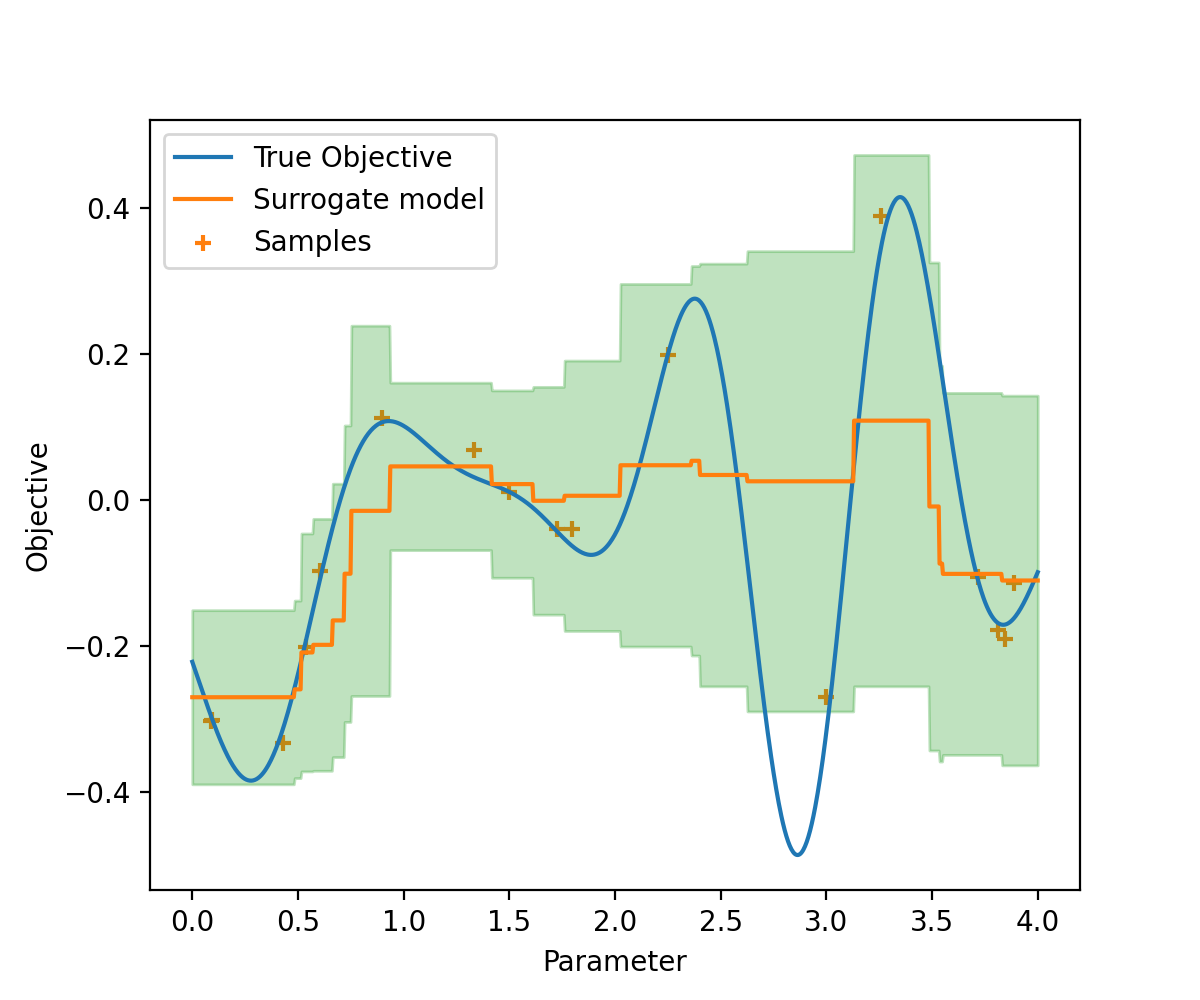

The surrogate model reports the best parameter is 0.42726696103811035 and the bext objective is -0.3321391015187381
The best parameter is [2.86286286] and the bext objective is -0.4858590750634986


<IPython.core.display.Javascript object>


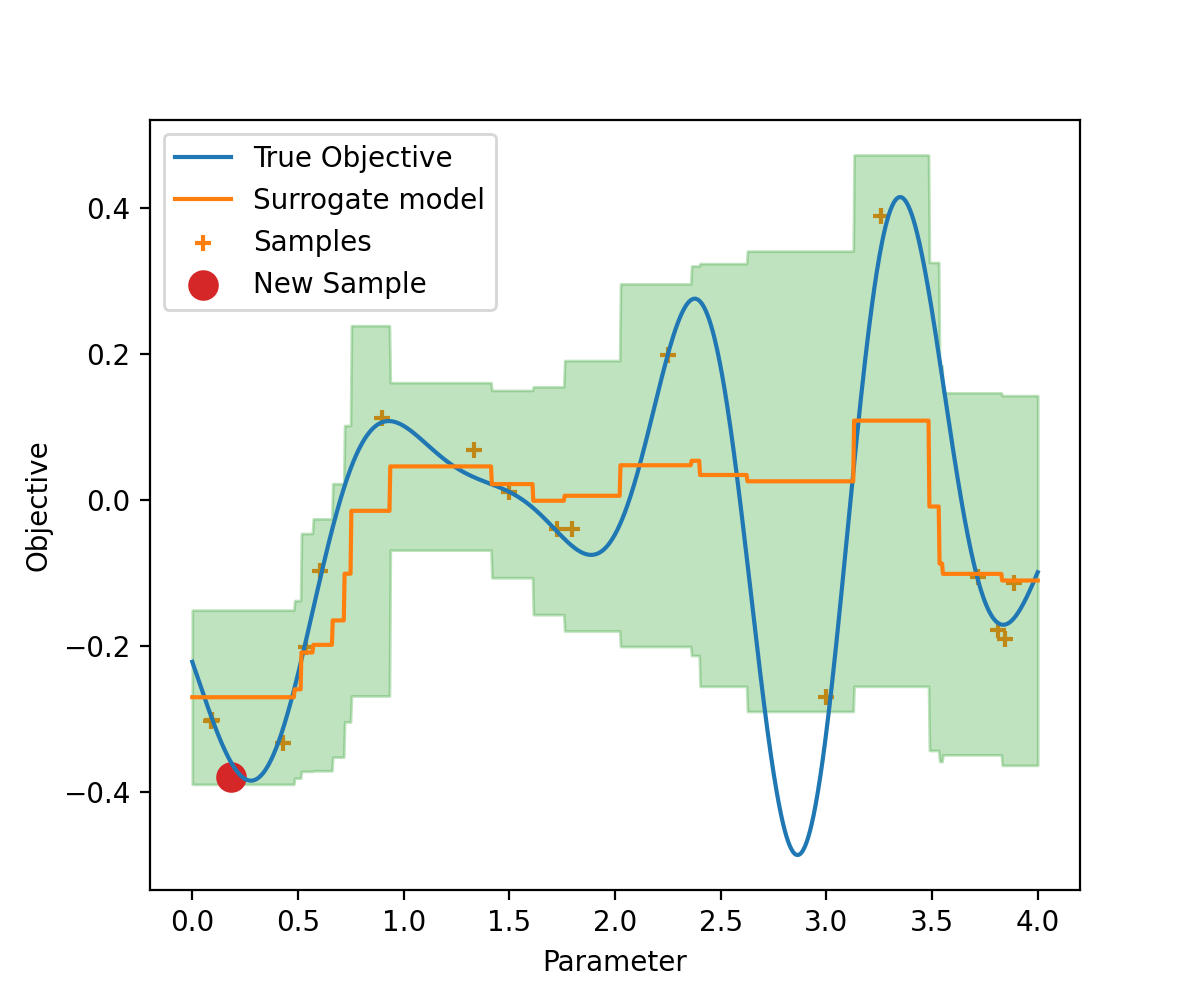

The surrogate model reports the best parameter is 0.18546212539162577 and the bext objective is -0.37877178456404814
The best parameter is [2.86286286] and the bext objective is -0.4858590750634986


<IPython.core.display.Javascript object>


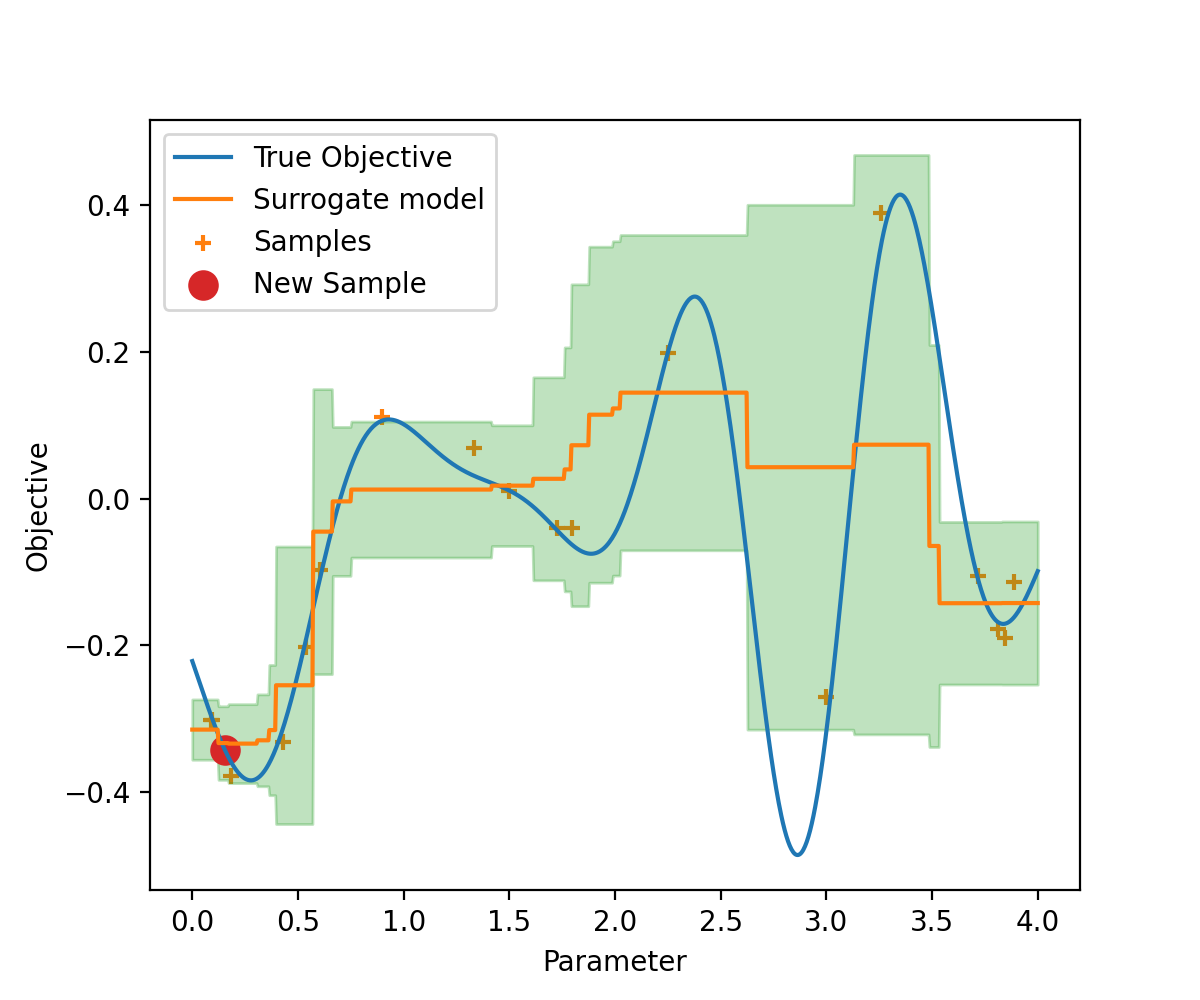

The surrogate model reports the best parameter is 0.18546212539162577 and the bext objective is -0.37877178456404814
The best parameter is [2.86286286] and the bext objective is -0.4858590750634986


<IPython.core.display.Javascript object>


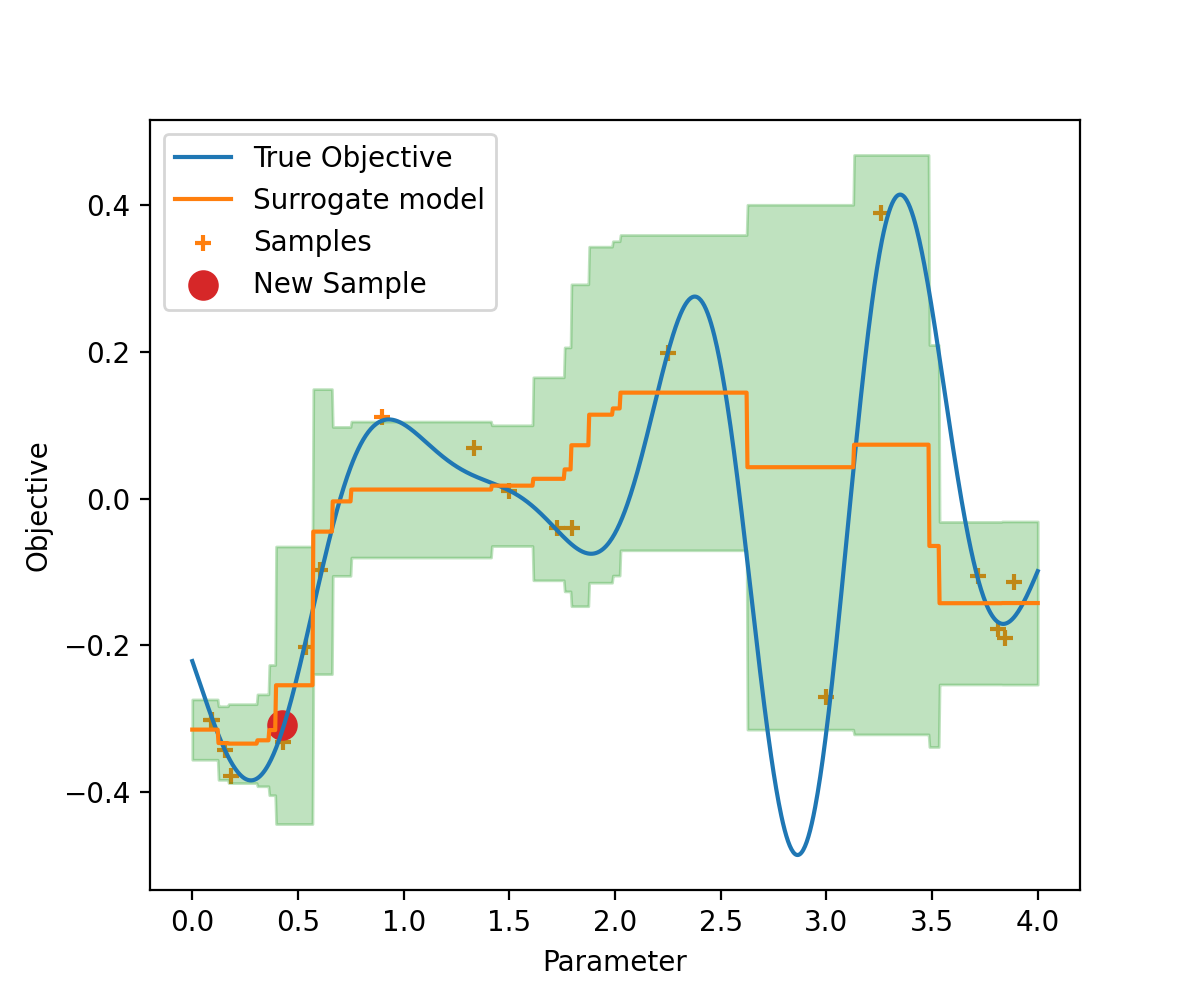

The surrogate model reports the best parameter is 0.18546212539162577 and the bext objective is -0.37877178456404814
The best parameter is [2.86286286] and the bext objective is -0.4858590750634986


In [12]:
alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha

def plot_mlos_model(optimizer, alpha, X_all, Y_all):
    y_pred_dict = optimizer.predict(pd.DataFrame({'x': X_all.squeeze()})).get_dataframe()

    t_values = t.ppf(1 - alpha / 2.0, y_pred_dict['predicted_value_degrees_of_freedom'])
    ci_radii = t_values * np.sqrt(y_pred_dict['predicted_value_variance'])

    plt.figure(figsize=(6, 5))
    
    plt.plot(X_all, Y_all, label='True Objective')
    plt.plot(X_all, y_pred_dict['predicted_value'], label='Surrogate model')
    X_s, Y_s, _ = optimizer.get_all_observations()
    plt.scatter(X_s, Y_s, color='C1', marker='+', label='Samples')
    plt.fill_between(X_all[:, 0], y_pred_dict['predicted_value']+ci_radii, y_pred_dict['predicted_value']-ci_radii, color='C2', alpha=0.3)

    plt.xlabel('Parameter')
    plt.ylabel('Objective')
    plt.legend()

    best_observation_config, best_observation_value = optimizer.optimum()

    print(f"The surrogate model reports the best parameter is {best_observation_config['x']} and the bext objective is {best_observation_value['function_value']}")
    print(f"The best parameter is {X_all[np.argmin(Y_all)]} and the bext objective is {np.min(Y_all)}")

optimizer.register(pd.DataFrame({'x': X_s.squeeze()}), pd.DataFrame({'function_value': Y_s.squeeze()}))
plot_mlos_model(optimizer, alpha, X_all, Y_all)

for i in range(3):
    suggested_value = optimizer.suggest()
    x_new = suggested_value['x']
    y_new = objective(x_new)
    
    optimizer.register(pd.DataFrame({'x': [x_new]}), pd.DataFrame({'function_value': [y_new]}))

    plot_mlos_model(optimizer, alpha, X_all, Y_all)
    plt.scatter(x_new, y_new, marker='o', s=100, color='C3', label='New Sample')
    plt.legend()

# Assigment 6
For the final assignment, let's see how well this optimizers fares against the previous Gaussian Process based ones.

Plot the **expectation** of error (y-axis) metric against the number of random samples (x-axis).

In [ ]:
sample_space = [10, 13, 16, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
error_mlos = np.empty_like(sample_space, dtype=float)

###### Assignment 6
# Compute the error of the explained approach.
###### 

plt.figure(figsize=(6, 5))
plt.plot(sample_space, error_simple, color='C0', label='Direct minimization')
plt.plot(sample_space, error_random, color='C1', label='BO - Random sampling')
plt.plot(sample_space, error_greedy, color='C2', label='BO - Greedy sampling')
plt.plot(sample_space, error_LCB, color='C3', label='BO - LCB sampling')
plt.plot(sample_space, error_mlos, color='C4', label='BO - MLOS Random Forest')
plt.xlabel('Number of samples')
plt.ylabel('Absolute error')
plt.legend()